In [66]:
import numpy as np
import pandas as pd
from IPython.display import Image
from datetime import datetime
from matplotlib import pyplot as plt
import yfinance as yf
from pypfopt import risk_models,expected_returns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt import plotting
import collections
import cvxpy as cp
from pulp import *

## Berkshire Hathaway Portfolio Composition:


As of April 2021, The Berkshire Hathaway's top 10 Positions is as follows:

AAPL – Apple Inc. 43.61%

BAC – Bank of America Corp. 11.34%  

KO – Coca Cola Co. 8.13%  

AXP – American Express 6.79%  

KHC – Kraft Heinz Co. 4.18%  

VZ – Verizon Communications 3.19%  

MCO – Moody’s Corp. 2.65%  

USB – U.S. Bancorp 2.26%  

DVA – DaVita HealthCare Partners 1.57%  

CVX – Chevron Corp. 1.52%

In [67]:
assets=[
        "WFC",#Wells Fargo
        "KO",#Coca Cola
        "AXP",#American Express
        "USB",#US Bancorp
         "AAPL",#Apple
         "JPM",#JP Morgan
         "KHC",#Kraft Heinz
         "BK",#Bank of New York
         "MCO",#Moodys
          "DVA",#DaVita HealthCare Partners
       ]
weights=[]
for asset in assets:
    weights.append(1/(len(assets)))
weights=np.array(weights)


In [68]:
stockStartDate="2019-01-01"

In [69]:
stockEndDate=datetime.today().strftime("%Y-%m-%d")

In [70]:
data = yf.download(assets, start="2020-01-01", end=stockEndDate)["Adj Close"]
data

[*********************100%***********************]  10 of 10 completed


,AAPL,AXP,BK,DVA,JPM,KHC,KO,MCO,USB,WFC
Date,,,,,,,,,,
2019-12-31,72.337982,120.897186,47.446751,75.029999,131.219864,29.549627,52.285233,234.097046,55.451778,51.025349
2020-01-02,73.988464,122.641548,48.002953,75.250000,132.810684,29.071388,51.945164,238.346878,55.367603,50.977924
2020-01-03,73.269142,121.423416,47.390186,75.080002,131.058075,28.731100,51.661777,237.755249,54.722267,50.664944
2020-01-06,73.852982,120.897179,47.833260,75.550003,130.953873,28.795477,51.642883,238.494766,53.974056,50.361446
2020-01-07,73.505646,120.263756,48.314045,75.110001,128.727585,28.289648,51.246136,237.636932,53.459671,49.944138
...,...,...,...,...,...,...,...,...,...,...
2021-11-01,148.742920,174.210007,60.020000,105.320000,169.800003,36.730000,56.169998,394.390015,60.779999,51.511112
2021-11-02,149.801376,173.169998,59.930000,104.059998,170.470001,37.080002,56.099998,390.700012,60.860001,51.102692
2021-11-03,151.269241,172.610001,60.090000,105.150002,170.529999,37.419998,56.290001,386.549988,61.830002,51.799999


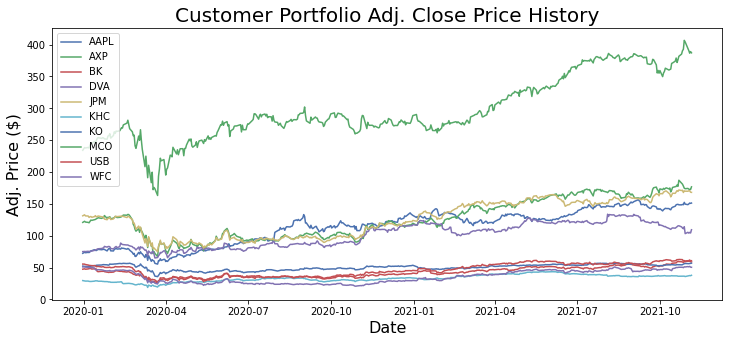

In [71]:
my_stocks=data
plt.figure(figsize=(12,5))
for c in my_stocks.columns.values:
    plt.plot(my_stocks[c], label=c)
plt.title("Customer Portfolio Adj. Close Price History", fontsize=20)
plt.legend(loc="upper left")
plt.xlabel("Date", fontsize=16)
plt.ylabel("Adj. Price ($)",fontsize=16)

plt.show()

In [72]:
returns=data.pct_change()

In [73]:
cov_matrix_annual=(returns.cov())*21*12

In [74]:
port_variance=np.dot(weights.T, np.dot(cov_matrix_annual, weights))

In [75]:
port_volatility=np.sqrt(port_variance)

In [76]:
portfolioSimpleAnnualReturn=np.sum(returns.mean()*weights)*21*12

In [77]:
percent_var = str(round(port_variance, 2) * 100) + '%'
percent_vols = str(round(port_volatility, 2) * 100) + '%'
percent_ret = str(round(portfolioSimpleAnnualReturn, 2)*100)+'%'
print("Expected annual return : "+ percent_ret)
print('Annual volatility/standard deviation/risk : '+percent_vols)
print('Annual variance : '+percent_var)

Expected annual return : 24.0%
Annual volatility/standard deviation/risk : 33.0%
Annual variance : 11.0%


In [78]:
mu = expected_returns.mean_historical_return(data)#returns.mean() * 252
S = risk_models.sample_cov(data)

In [91]:
ef=EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights() 
print(cleaned_weights)

OrderedDict([('AAPL', 0.94632), ('AXP', 0.0), ('BK', 0.0), ('DVA', 0.05368), ('JPM', 0.0), ('KHC', 0.0), ('KO', 0.0), ('MCO', 0.0), ('USB', 0.0), ('WFC', 0.0)])


In [95]:
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt(np.diag(w @ S @ w.T))
sharpes = rets / stds

Expected annual return: 48.9%
Annual volatility: 38.1%
Sharpe Ratio: 1.23


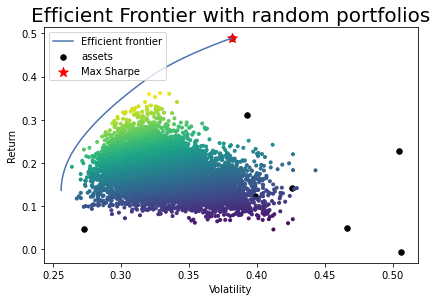

In [100]:
ef=EfficientFrontier(mu, S)
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef)
ef.portfolio_performance(verbose=True)
ret_tangent, std_tangent, _ = ef.portfolio_performance()
plt.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")
plt.scatter(stds, rets, marker=".", c=sharpes)
plt.title("Efficient Frontier with random portfolios", fontsize=20)
plt.legend(loc="upper left")
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

In [104]:
latest_prices = get_latest_prices(data)
weights = cleaned_weights 
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=100000)
allocation, leftover = da.lp_portfolio()
print("Discrete Allocation:", allocation)
print("Funds: {}$ are left".format(leftover))

SolverError: The solver GLPK_MI is not installed.